In [1]:
import torch
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import List, Optional
from tqdm import tqdm

# Configuration matplotlib pour LaTeX
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 18
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.formatter.limits'] = (-6, 6)
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True

In [2]:
# --- 1. Centralisation des Paramètres ---


@dataclass
class OTConfig:
    """Configuration pour Transport Optimal 5D."""

    # Résolution de travail (la grille de calcul)
    # 32x32 ou 48x48 recommandé pour test rapide (O(N^2))
    # 64x64 est faisable sur GPU (< 5 sec avec KeOps)
    resolution: tuple[int] = (64, 64)

    # Échelle de flou entropique (Epsilon).
    blur: float = 0.01

    # Scaling GeomLoss (Précision)
    scaling: float = 0.9

    # Unbalanced parameter (rho). None = Balanced.
    reach: Optional[float] = 0.7

    # Poids de la couleur dans le coût 5D.
    # lambda ~ 0.5 à 2.0.
    # Si très grand -> transporte uniquement les couleurs (ignore l'espace).
    lambda_color: float = 1.0

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Paramètres du Splatting Adaptatif
    sigma_start: float = 1.2  # Large pour le Pixel Art (remplit les gros blocs)
    sigma_end: float = 0.5  # Fin pour la Photo (détails nets)
    sigma_boost: float = 0.5  # Boost supplémentaire à t=0.5 pour le tearing
    
    # Mode de splatting: "none", "fixed", "adaptive"
    splatting_mode: str = "adaptive"

In [3]:
# --- 2. Utilitaires Vectorisés ---


def get_5d_cloud(img: torch.Tensor, res: int, lambda_c: float):
    """
    Convertit une image (C, H, W) en nuage de points 5D (N, 5).
    Dimensions: [x, y, lambda*r, lambda*g, lambda*b]
    Masse: Uniforme (1/N) pour chaque pixel non ignoré.
    """
    C, H, W = img.shape

    # Downsampling
    scale = res / max(H, W)
    new_H, new_W = int(H * scale), int(W * scale)
    if new_H != H or new_W != W:
        img = F.interpolate(
            img.unsqueeze(0), size=(new_H, new_W), mode="bilinear"
        ).squeeze(0)

    # Coordonnées (x, y) normalisées dans [0, 1]
    y = torch.linspace(0, 1, new_H, device=img.device)
    x = torch.linspace(0, 1, new_W, device=img.device)
    yy, xx = torch.meshgrid(y, x, indexing="ij")

    # (N, 2) spatial
    pos_spatial = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

    # (N, 3) couleur
    colors = img.permute(1, 2, 0).reshape(-1, C)

    # Concaténation 5D : [Space, Lambda * Color]
    # On pondère la couleur pour équilibrer le coût
    cloud_5d = torch.cat([pos_spatial, lambda_c * colors], dim=-1)

    # Masses uniformes (pour traiter tout le monde à égalité)
    # Note: On pourrait filtrer les pixels noirs ici si on voulait faire du "Sparse OT"
    N = cloud_5d.shape[0]
    weights = torch.ones(N, device=img.device) / N

    return cloud_5d, weights, colors, new_H, new_W


def vectorized_gaussian_splatting(positions_2d, attributes, weights, H, W, sigma):
    """
    Splatting Vectorisé (Nadaraya-Watson Kernel Regression).

    positions_2d : (N, 2) coordonnées spatiales dans [0, 1]
    attributes   : (N, C) valeurs à splatter (ici RGB)
    weights      : (N,) masse des particules
    sigma        : écart-type du noyau gaussien (en pixels)

    Retourne : (C, H, W) Image reconstruite
    """
    device = positions_2d.device
    N = positions_2d.shape[0]

    # Conversion en coordonnées pixels
    pos_pix = positions_2d * torch.tensor([W - 1, H - 1], device=device)

    # Rayon du noyau (3 sigma couvre 99%)
    radius = int(np.ceil(3 * sigma))
    diameter = 2 * radius + 1

    # --- 1. Définition de la grille locale (Broadcasting) ---
    # Coordonnées entières du centre (N, 2)
    center_pix = torch.round(pos_pix).long()

    # Offsets locaux : grille de taille (diameter, diameter)
    # Création d'une grille locale relative (K*K, 2)
    d_range = torch.arange(-radius, radius + 1, device=device)
    dy, dx = torch.meshgrid(d_range, d_range, indexing="ij")
    offsets = torch.stack([dx, dy], dim=-1).reshape(-1, 2)  # (K*K, 2)

    # Voisins : (N, K*K, 2)
    # neighbor_coords[i, k] = pixel absolu du k-ième voisin de la particule i
    neighbor_coords = center_pix.unsqueeze(1) + offsets.unsqueeze(0)

    # Masque de validité (dans l'image)
    x_neigh = neighbor_coords[:, :, 0]
    y_neigh = neighbor_coords[:, :, 1]
    mask = (x_neigh >= 0) & (x_neigh < W) & (y_neigh >= 0) & (y_neigh < H)

    # --- 2. Calcul des poids Gaussiens ---
    # Position flottante précise projetée sur la grille voisine
    # dist_sq = || pos_pix - neighbor_coords ||^2
    # astuce : pos_pix shape (N, 1, 2), neighbor shape (N, K*K, 2)
    dist_sq = ((pos_pix.unsqueeze(1) - neighbor_coords.float()) ** 2).sum(dim=-1)

    # Gaussian kernel: w_ik
    gauss_weights = torch.exp(-dist_sq / (2 * sigma**2))

    # Application du masque et de la masse de la particule
    # total_weight_ik = pi_i * K(dist) * mask
    contrib_weights = (gauss_weights * weights.unsqueeze(1)) * mask.float()

    # --- 3. Accumulation (Scatter) ---
    # On a besoin d'indices linéaires pour scatter_add
    # flat_indices : (N, K*K) -> indices dans l'image aplatie (H*W)
    flat_indices = y_neigh * W + x_neigh

    # Pour ne pas scatter hors bornes avec les indices masqués, on clamp à 0 (et le poids est 0)
    flat_indices = flat_indices.clamp(0, H * W - 1)

    # A. Accumulateur de poids (Dénominateur)
    denom = torch.zeros(H * W, device=device)
    denom.scatter_add_(0, flat_indices.view(-1), contrib_weights.view(-1))

    # B. Accumulateur de couleurs (Numérateur)
    # attributes : (N, 3) -> (N, 1, 3)
    # weighted_attribs : (N, K*K, 3)
    weighted_attribs = attributes.unsqueeze(1) * contrib_weights.unsqueeze(-1)

    C_channels = attributes.shape[1]
    numer = torch.zeros(H * W, C_channels, device=device)

    # On doit iterer sur les channels ou reshaper, scatter_add gère mal le multidim direct sur index 1D
    for c in range(C_channels):
        val_c = weighted_attribs[:, :, c].view(-1)
        numer[:, c].scatter_add_(0, flat_indices.view(-1), val_c)

    # --- 4. Normalisation ---
    # Éviter division par zéro
    denom = denom.clamp(min=1e-6)

    # Image finale
    out_img = numer / denom.unsqueeze(1)  # (H*W, C)
    out_img = out_img.reshape(H, W, C_channels).permute(2, 0, 1)  # (C, H, W)

    return out_img


def compute_sinkhorn_evolution(frames, img_target, config):
    """
    Calcule la divergence de Sinkhorn S_eps(frame_t, target) pour chaque frame.

    Args:
        frames: Liste des tenseurs (C, H, W) générés par l'interpolation.
        img_target: Tenseur cible (C, H, W).
        config: Ta configuration OTConfig utilisée pour le transport.
    """

    # On réutilise la même configuration de Loss que pour le transport
    # GeomLoss calcule S_eps par défaut (debias=True est le défaut implicite souvent,
    # mais on peut le forcer pour être sûr d'avoir la formule Eq. 14 du papier).
    # Note: Pour une mesure scalaire précise, on utilise potentials=False (par défaut).
    metric_loss = SamplesLoss(
        loss="sinkhorn",
        p=2,
        blur=config.blur,
        reach=config.reach,
        scaling=config.scaling,
        
        debias=True,  # Active la formule S_eps = OT_ab - 0.5*OT_aa - 0.5*OT_bb
    )

    distances = []

    # 1. Préparation de la cible en Nuage 5D
    # On utilise ta fonction existante get_5d_cloud
    target_cloud, target_weights, _, _, _ = get_5d_cloud(
        img_target.to(config.device), config.resolution[1], config.lambda_color
    )

    for i, frame in enumerate(frames):
        # 2. Conversion de la frame générée (image) en Nuage 5D
        # C'est crucial : on compare dans l'espace 5D (Geometry + Color)
        current_cloud, current_weights, _, _, _ = get_5d_cloud(
            frame.to(config.device),
            config.resolution[0],  # Ou la résolution de la frame si différente
            config.lambda_color,
        )

        # 3. Calcul de la perte S_eps(mu_t, nu)
        # SamplesLoss attend (weights, positions)
        loss_val = metric_loss(
            current_weights, current_cloud, target_weights, target_cloud
        )

        distances.append(loss_val.item())

    return distances

In [4]:
# --- 3. Moteur de Transport 5D ---


class OT5DInterpolator:
    def __init__(self, config: OTConfig):
        self.cfg = config
        self.loss_layer = SamplesLoss(
            loss="sinkhorn", p=2, blur=config.blur, reach=config.reach,
            debias=False, potentials=True, scaling=config.scaling, backend="auto"
        )

    def interpolate(self, img_source, img_target, times: List[float]):
        """Interpolation de Wasserstein avec barycentres géodésiques - SANS SPLATTING.
        
        Utilise uniquement le barycentre géodésique pur, sans flou gaussien.
        Code basé sur plot_lambda_ablation.py qui donne les bons résultats.
        """
        img_source_device = img_source.to(self.cfg.device)
        X_a, w_a, colors_a, Ha, Wa = get_5d_cloud(
            img_source_device, self.cfg.resolution[0], self.cfg.lambda_color
        )
        X_b, w_b, colors_b, Hb, Wb = get_5d_cloud(
            img_target.to(self.cfg.device), self.cfg.resolution[1], self.cfg.lambda_color
        )
        F_pot, G_pot = self.loss_layer(w_a, X_a, w_b, X_b)
        F_pot, G_pot = F_pot.flatten(), G_pot.flatten()
        dist_sq = torch.cdist(X_a, X_b, p=2) ** 2
        C_matrix = dist_sq / 2.0
        epsilon = self.cfg.blur**2
        log_pi = (
            (F_pot[:, None] + G_pot[None, :] - C_matrix) / epsilon
            + torch.log(w_a.flatten()[:, None])
            + torch.log(w_b.flatten()[None, :])
        )
        pi = torch.exp(log_pi).squeeze()
        mask = pi > (pi.max() * 1e-4)
        I_idx, J_idx = mask.nonzero(as_tuple=True)
        weights_ij = pi[I_idx, J_idx]
        pos_a_spatial = X_a[I_idx, :2]
        pos_b_spatial = X_b[J_idx, :2]
        col_a_real = colors_a[I_idx]
        col_b_real = colors_b[J_idx]
        results = []
        N_active = weights_ij.shape[0]
        
        for t in tqdm(times, desc="Interpolation 5D", leave=False):
            # Calculer l'interpolation pour tous les temps (y compris t=0 et t=1)
            # pour voir l'effet des paramètres même aux extrémités
            pos_t = (1 - t) * pos_a_spatial + t * pos_b_spatial
            col_t = (1 - t) * col_a_real + t * col_b_real
            Ht = int((1 - t) * Ha + t * Hb)
            Wt = int((1 - t) * Wa + t * Wb)
            
            # Décider si on utilise le splatting ou le placement direct
            use_no_splatting = (self.cfg.splatting_mode == "none" or 
                               (self.cfg.sigma_start == 0.0 and self.cfg.sigma_end == 0.0))
            
            if use_no_splatting:
                # Placement direct sans splatting : scatter les pixels aux positions interpolées
                pos_pix = pos_t * torch.tensor([Wt - 1, Ht - 1], device=pos_t.device)
                img_t = torch.zeros(3, Ht, Wt, device=pos_t.device)
                x_indices = (pos_pix[:, 0] + 0.5).long().clamp(0, Wt - 1)
                y_indices = (pos_pix[:, 1] + 0.5).long().clamp(0, Ht - 1)
                
                # Accumuler les couleurs pondérées
                for c in range(3):
                    img_t[c].index_put_(
                        (y_indices, x_indices), 
                        col_t[:, c] * weights_ij,
                        accumulate=True
                    )
                
                # Normaliser par les poids accumulés
                count = torch.zeros(Ht, Wt, device=pos_t.device)
                count.index_put_((y_indices, x_indices), weights_ij, accumulate=True)
                count = count.clamp(min=1e-6)
                img_t = img_t / count.unsqueeze(0)
            elif self.cfg.splatting_mode == "fixed":
                # Splatting fixe avec sigma moyen
                sigma_t = (self.cfg.sigma_start + self.cfg.sigma_end) / 2.0
                current_spacing = np.sqrt((Ht * Wt) / (N_active + 1e-6))
                min_sigma_t = current_spacing / 2.0
                sigma_t = max(sigma_t, min_sigma_t * 0.8)
                img_t = vectorized_gaussian_splatting(
                    pos_t, col_t, weights_ij, Ht, Wt, sigma=sigma_t
                )
            else:  # adaptive
                # Sigma "Intelligent" (code original)
                sigma_intrinsic = (1 - t) * self.cfg.sigma_start + t * self.cfg.sigma_end
                sigma_expansion = self.cfg.sigma_boost * 4 * t * (1 - t)
                current_spacing = np.sqrt((Ht * Wt) / (N_active + 1e-6))
                min_sigma_t = current_spacing / 2.0
                sigma_t = max(sigma_intrinsic + sigma_expansion, min_sigma_t * 0.8)
                img_t = vectorized_gaussian_splatting(
                    pos_t, col_t, weights_ij, Ht, Wt, sigma=sigma_t
                )
            
            results.append(img_t.cpu())
        
        return results

100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


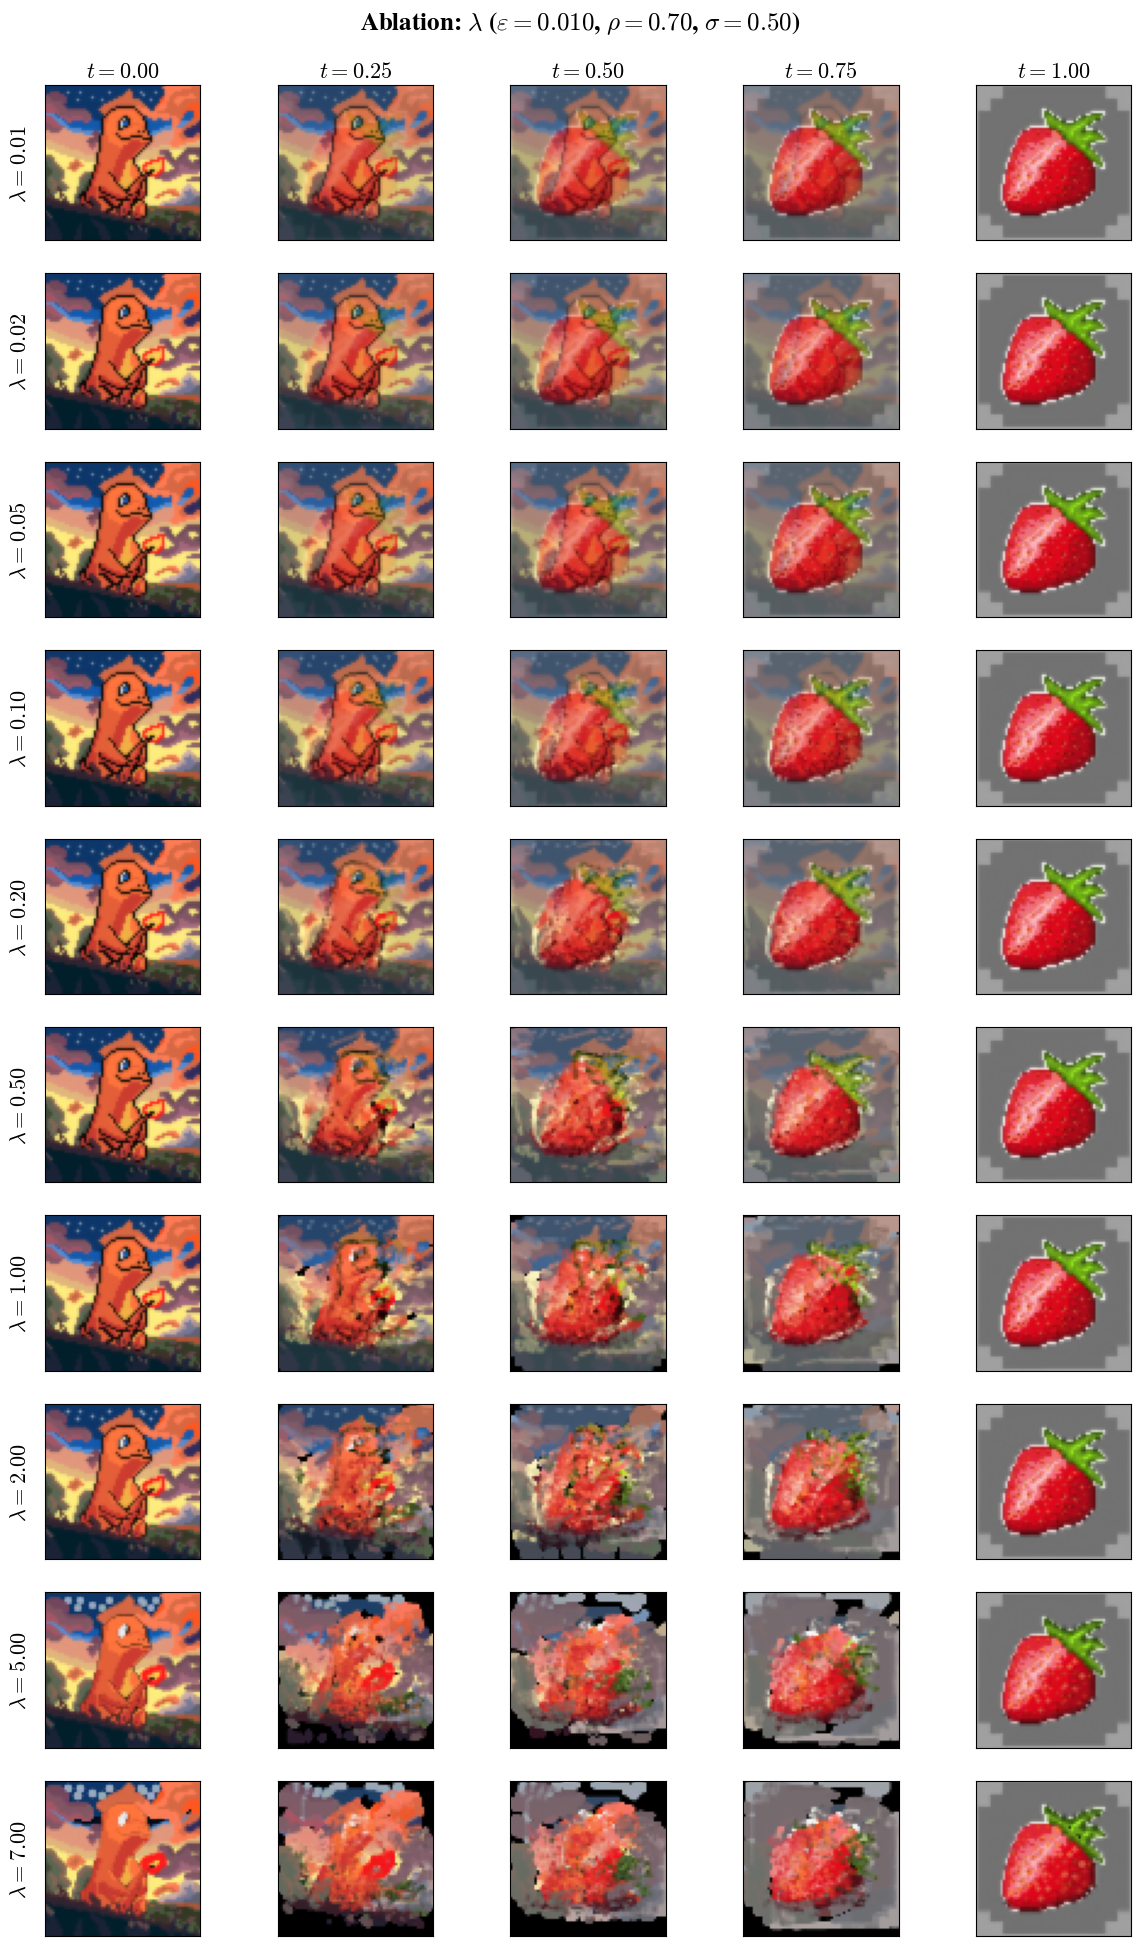

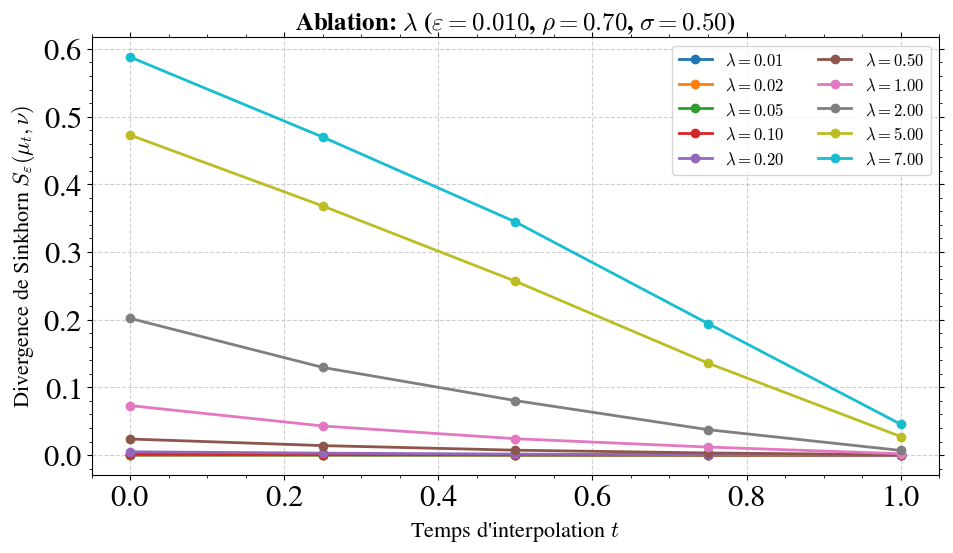

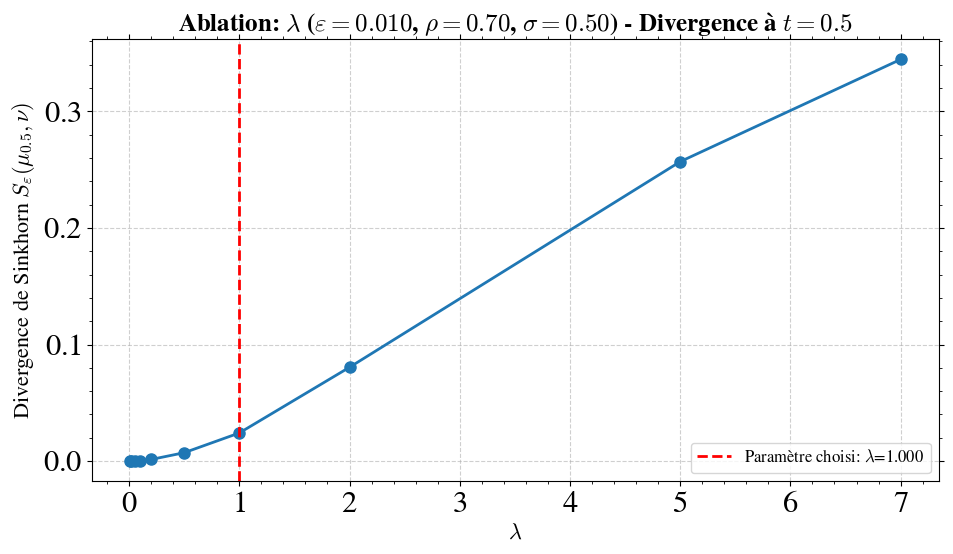

100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


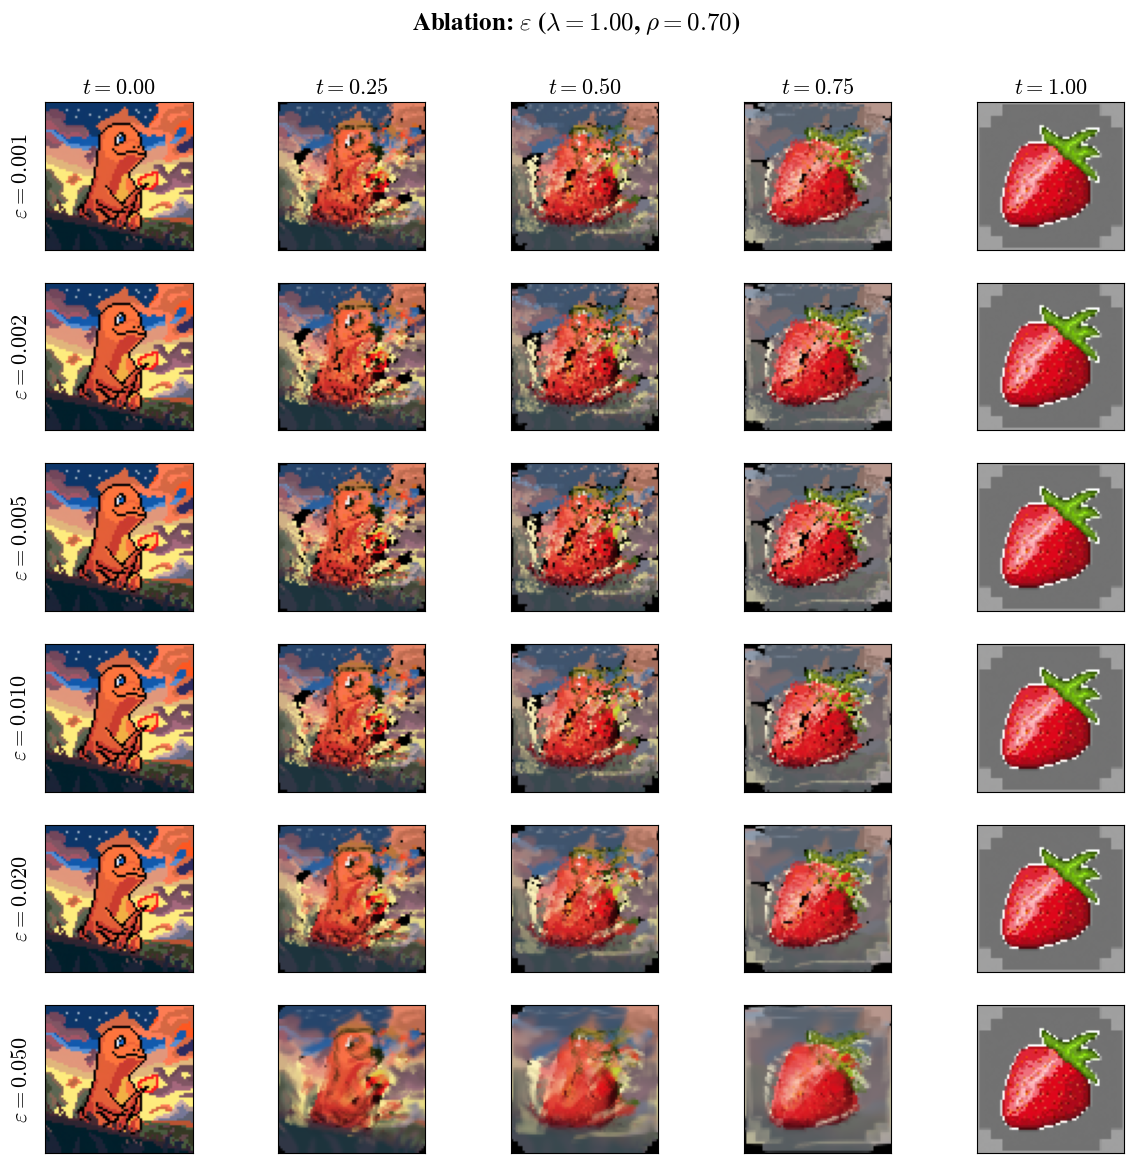

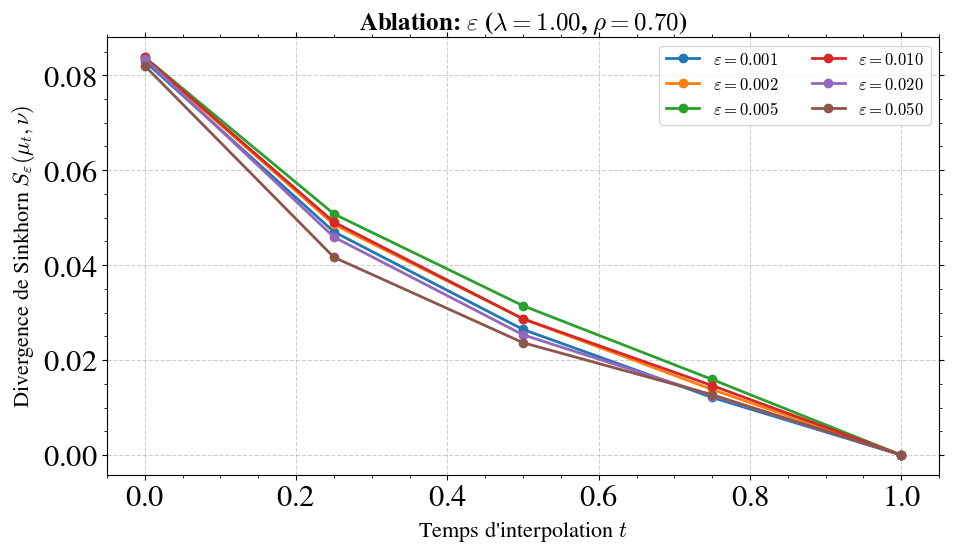

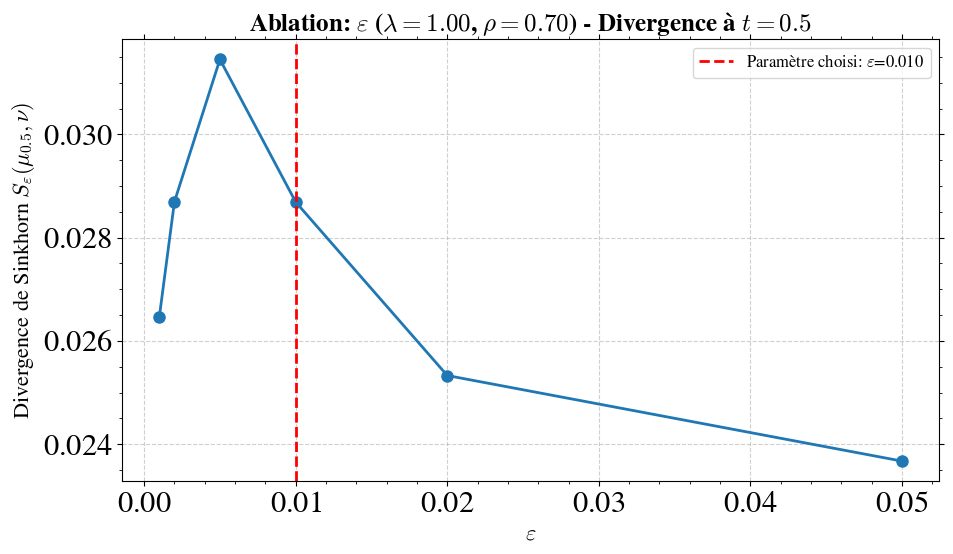

100%|██████████| 12/12 [00:52<00:00,  4.35s/it]


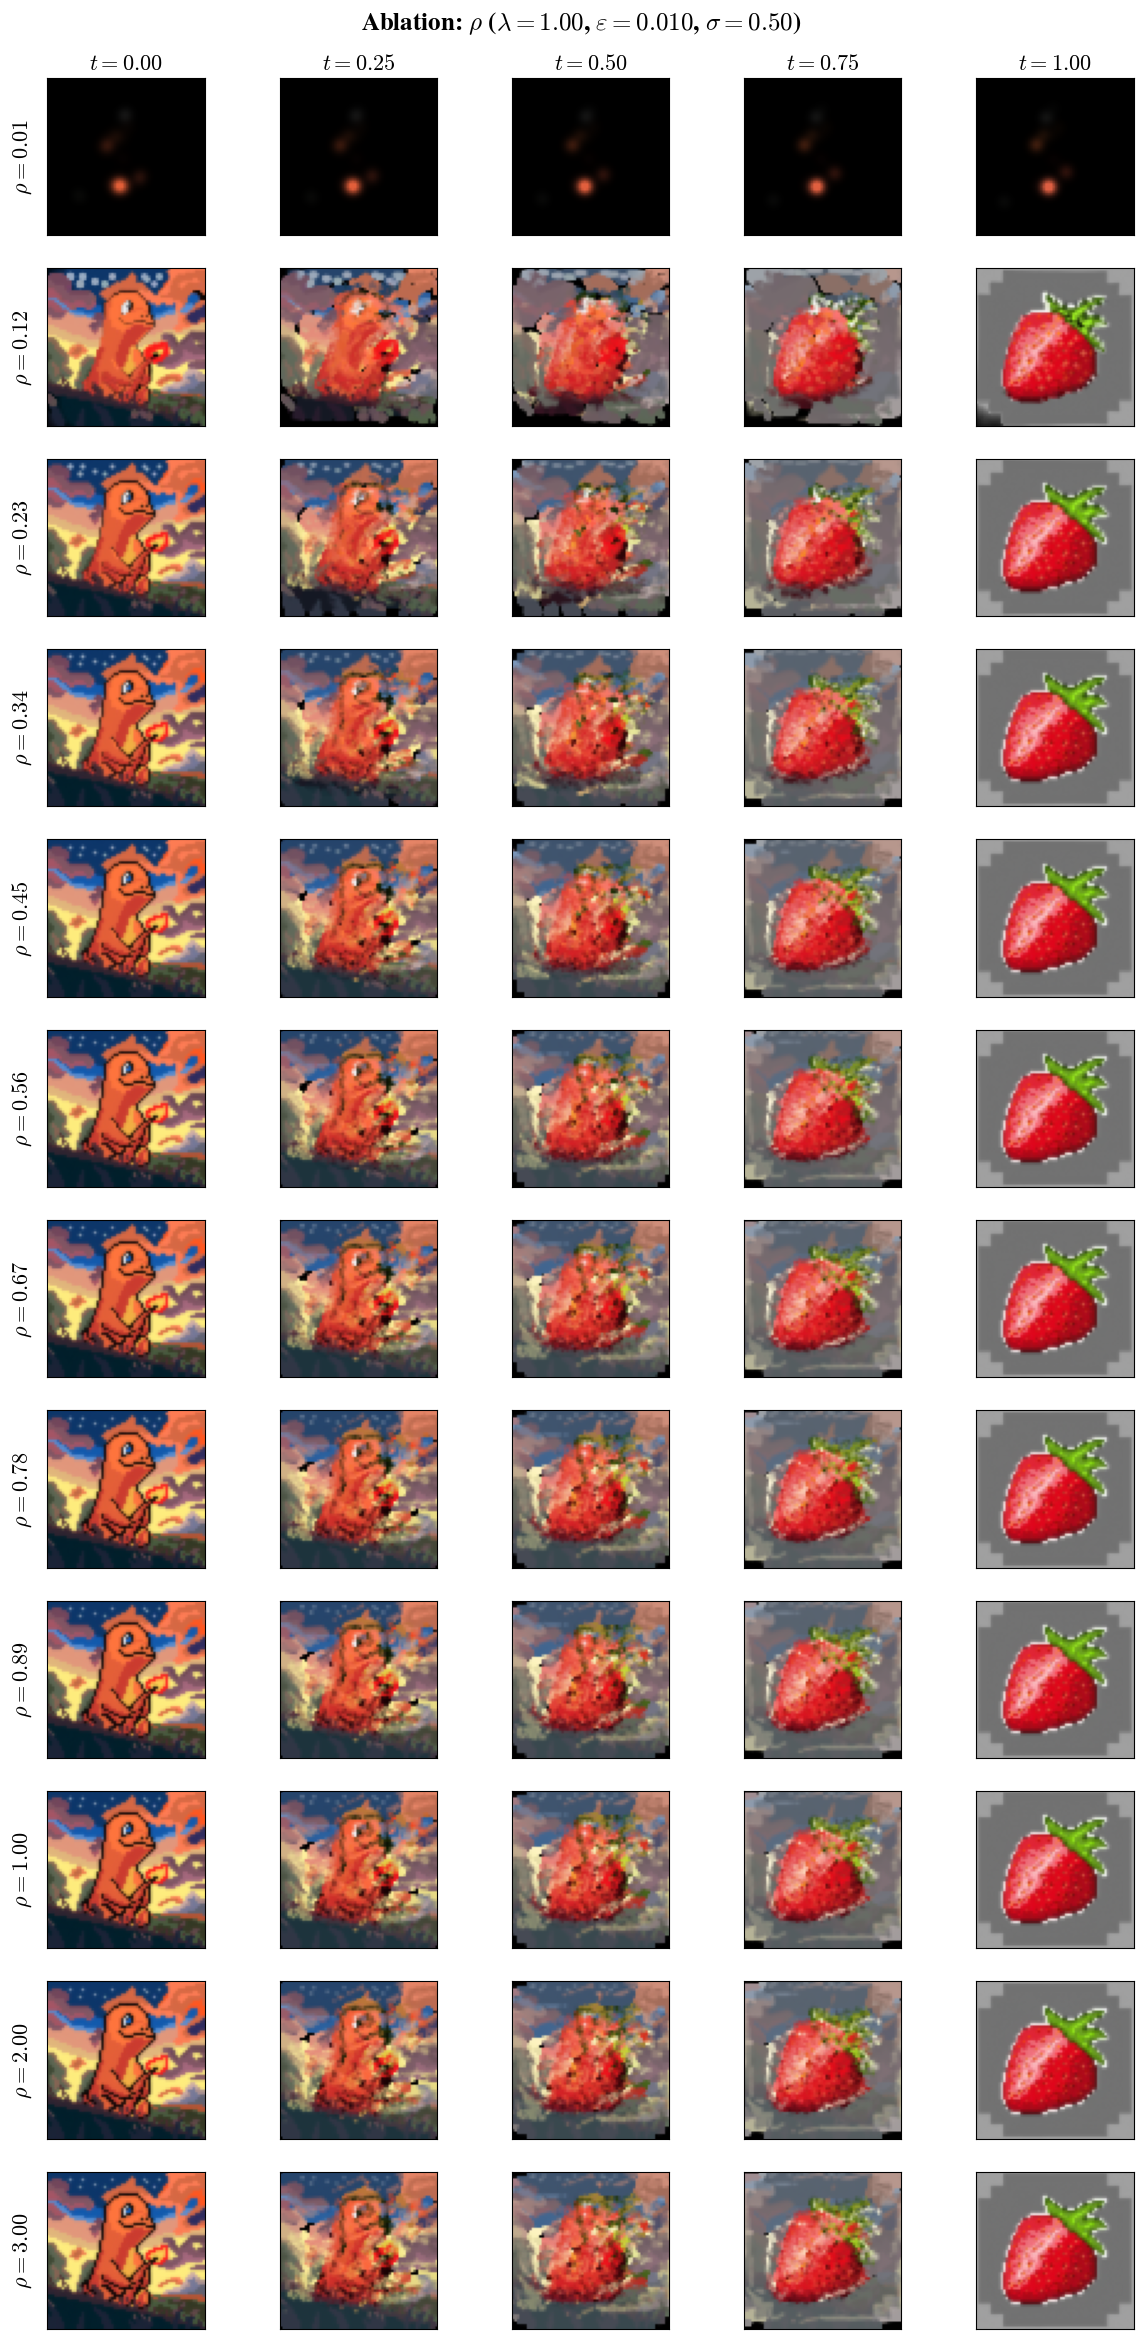

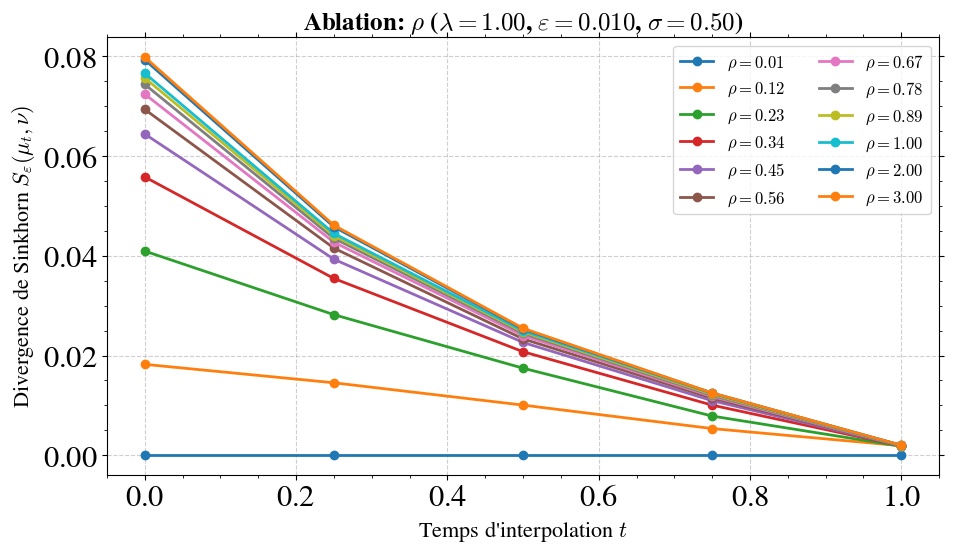

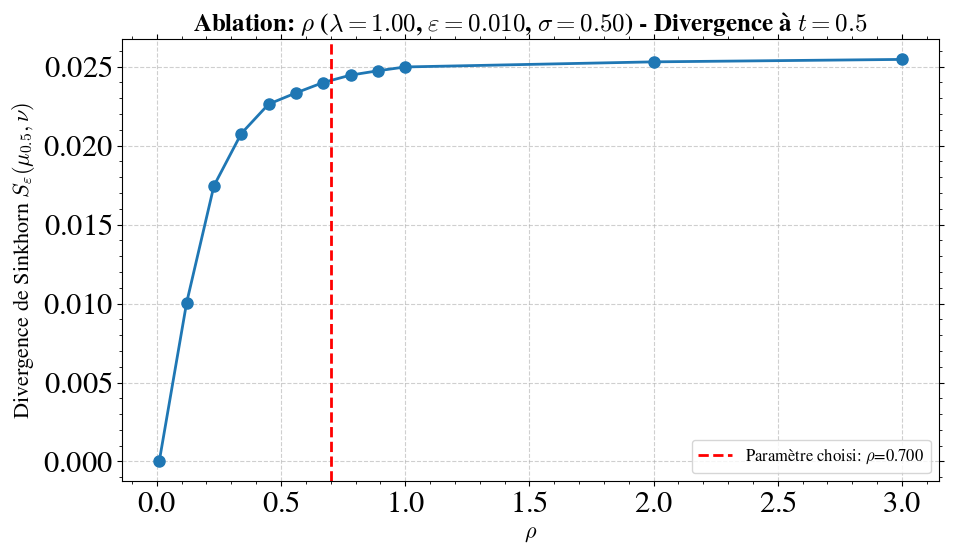

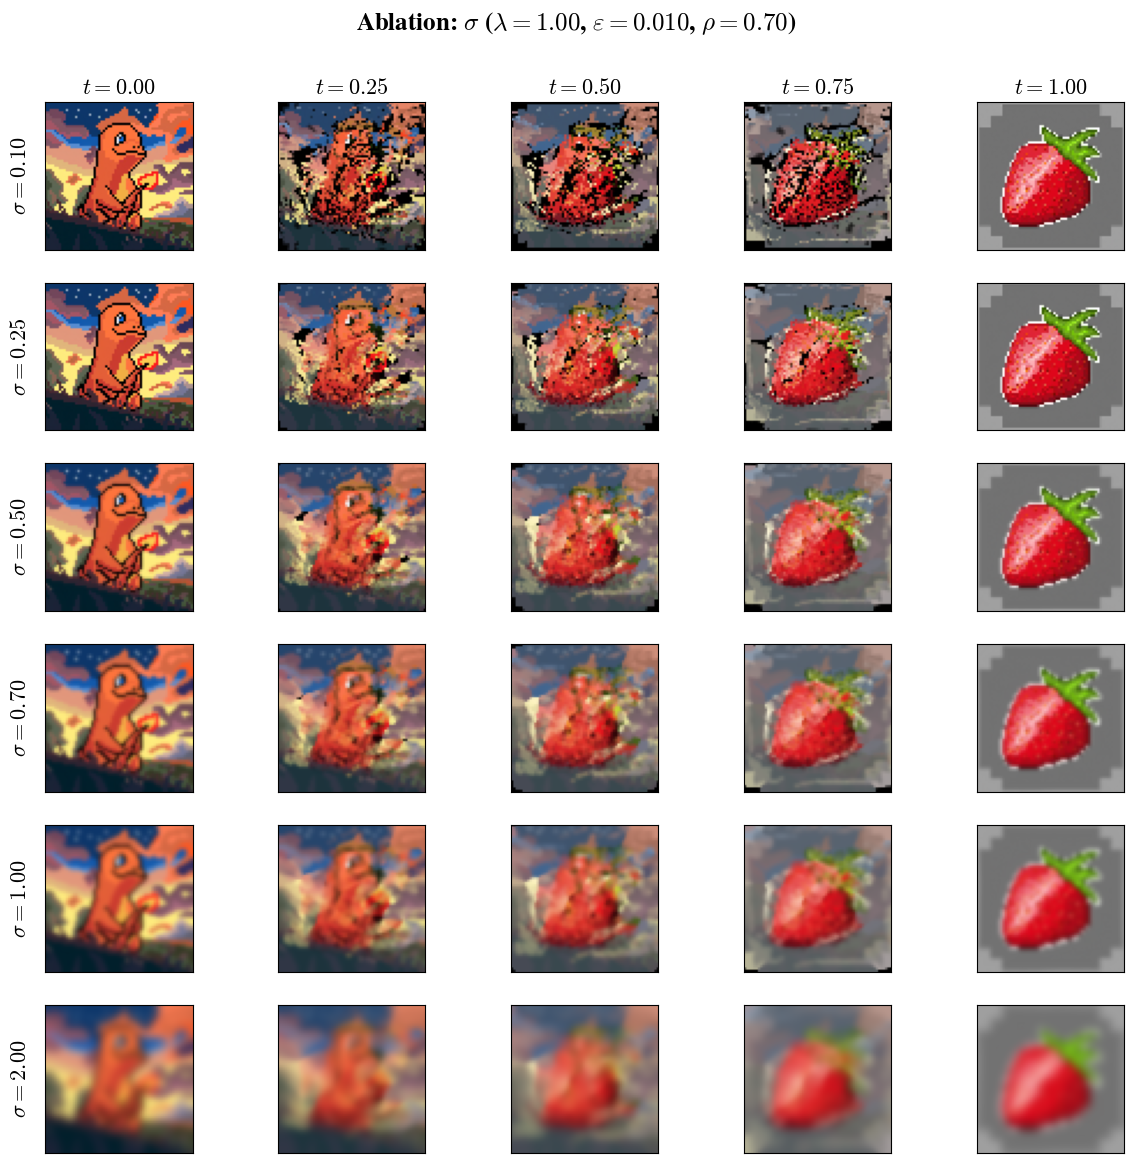

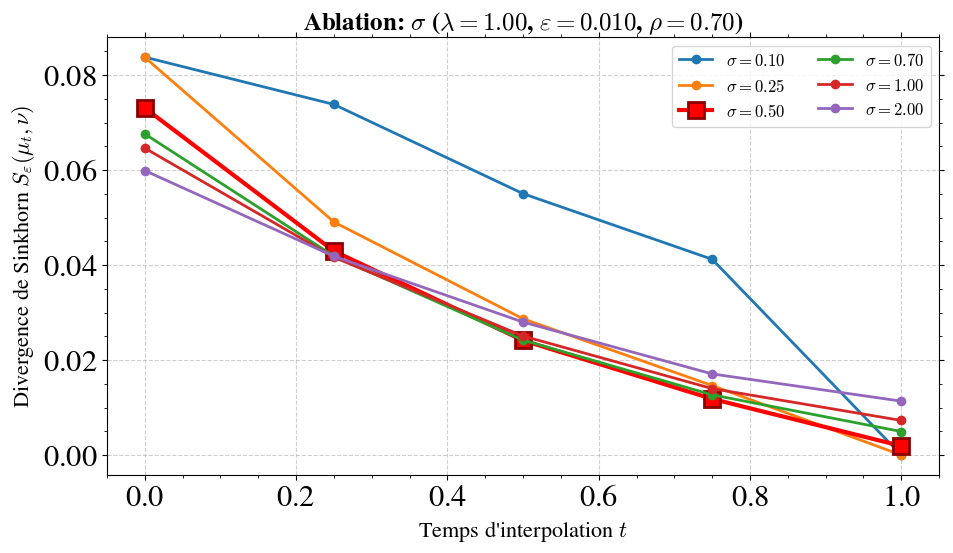

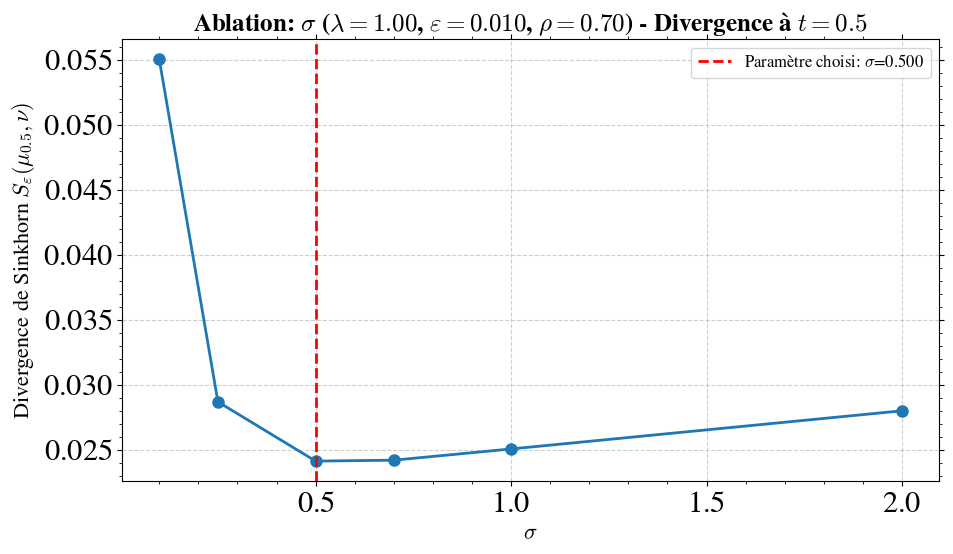

In [5]:
# --- 4. Main ---

def run_ablation_study(param_name, param_values, base_config_dict, img1, img2, times):
    """Run ablation study for a given parameter."""
    all_results = {}
    all_distances = {}
    
    for param_val in tqdm(param_values,):
        config_dict = base_config_dict.copy()
        config_dict[param_name] = param_val
        
        config = OTConfig(
            resolution=config_dict.get("resolution",(32, 64)),
            blur=config_dict.get("blur", 0.05),
            reach=config_dict.get("reach", 0.3),
            lambda_color=config_dict.get("lambda_color", 2.0),
            sigma_start=config_dict.get("sigma_start", 0.5),
            sigma_end=config_dict.get("sigma_end", 0.5),
            sigma_boost=config_dict.get("sigma_boost", 0.4),
            splatting_mode=config_dict.get("splatting_mode", "fixed"),
        )
        
        label = f"{param_name}={param_val:.3f}" if isinstance(param_val, float) else f"{param_name}={param_val}"
        
        interpolator = OT5DInterpolator(config)
        frames = interpolator.interpolate(img1, img2, times)
        
        all_results[label] = frames
        distances = compute_sinkhorn_evolution(frames, img2, config)
        all_distances[label] = distances
    
    return all_results, all_distances

def plot_ablation_results(all_results, all_distances, param_name, times, base_config_dict):
    """Plot timelines and divergence decay for each parameter value."""
    # Trier par valeur de paramètre
    param_values = []
    sorted_items_dist = []
    sorted_items_frames = []
    for label, distances in all_distances.items():
        try:
            val = float(label.split("=")[1])
            param_values.append(val)
            sorted_items_dist.append((val, label, distances))
            if label in all_results:
                sorted_items_frames.append((val, label, all_results[label]))
        except:
            sorted_items_dist.append((0, label, distances))
            if label in all_results:
                sorted_items_frames.append((0, label, all_results[label]))
    
    sorted_items_dist.sort(key=lambda x: x[0])
    sorted_items_frames.sort(key=lambda x: x[0])
    
    # Plot des timelines
    n_configs = len(sorted_items_frames)
    n_times = len(times)
    
    fig, axes = plt.subplots(n_configs, n_times, figsize=(2.5 * n_times, 2 * n_configs))
    if n_configs == 1:
        axes = axes.reshape(1, -1)
    
    for i, (param_val, label, frames) in enumerate(sorted_items_frames):
        for j, t in enumerate(times):
            ax = axes[i, j]
            ax.imshow(frames[j].permute(1, 2, 0).clamp(0, 1).numpy())
            if i == 0:
                ax.set_title(f"$t={t:.2f}$", fontsize=16)
            if j == 0:
                # Afficher la valeur du paramètre sur la première colonne avec format LaTeX
                if param_name == "lambda_color":
                    ax.set_ylabel(f"$\\lambda={param_val:.2f}$", rotation=90, size=16, fontweight='bold', labelpad=10)
                elif param_name == "blur":
                    ax.set_ylabel(f"$\\varepsilon={param_val:.3f}$", rotation=90, size=16, fontweight='bold', labelpad=10)
                elif param_name == "reach":
                    ax.set_ylabel(f"$\\rho={param_val:.2f}$", rotation=90, size=16, fontweight='bold', labelpad=10)
                elif param_name == "sigma":
                    ax.set_ylabel(f"$\\sigma={param_val:.2f}$", rotation=90, size=16, fontweight='bold', labelpad=10)
                else:
                    ax.set_ylabel(f"${param_name}={param_val:.3f}$", rotation=90, size=16, fontweight='bold', labelpad=10)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Créer le titre avec les autres paramètres
    title_parts = []
    if param_name != "lambda_color":
        title_parts.append(f"$\\lambda={base_config_dict.get('lambda_color', 2.0):.2f}$")
    if param_name != "blur":
        title_parts.append(f"$\\varepsilon={base_config_dict.get('blur', 0.05):.3f}$")
    if param_name != "reach":
        title_parts.append(f"$\\rho={base_config_dict.get('reach', 0.3):.2f}$")
    if param_name != "sigma":
        sigma_val = base_config_dict.get('sigma_start', 0.5)
        if sigma_val == base_config_dict.get('sigma_end', 0.5):
            title_parts.append(f"$\\sigma={sigma_val:.2f}$")
    
    # Créer le titre avec le nom du paramètre
    if param_name == "lambda_color":
        title = "Ablation: $\\lambda$"
    elif param_name == "blur":
        title = "Ablation: $\\varepsilon$"
    elif param_name == "reach":
        title = "Ablation: $\\rho$"
    elif param_name == "sigma":
        title = "Ablation: $\\sigma$"
    else:
        title = f"Ablation: {param_name}"
    
    if title_parts:
        title += f" ({', '.join(title_parts)})"
    
    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot des divergences
    
    # Créer le titre avec les autres paramètres
    title_parts = []
    if param_name != "lambda_color":
        title_parts.append(f"$\\lambda={base_config_dict.get('lambda_color', 2.0):.2f}$")
    if param_name != "blur":
        title_parts.append(f"$\\varepsilon={base_config_dict.get('blur', 0.05):.3f}$")
    if param_name != "reach":
        title_parts.append(f"$\\rho={base_config_dict.get('reach', 0.3):.2f}$")
    if param_name != "sigma":
        sigma_val = base_config_dict.get('sigma_start', 0.5)
        if sigma_val == base_config_dict.get('sigma_end', 0.5):
            title_parts.append(f"$\\sigma={sigma_val:.2f}$")
    
    # Créer le titre avec le nom du paramètre
    if param_name == "lambda_color":
        title = "Ablation: $\\lambda$"
    elif param_name == "blur":
        title = "Ablation: $\\varepsilon$"
    elif param_name == "reach":
        title = "Ablation: $\\rho$"
    elif param_name == "sigma":
        title = "Ablation: $\\sigma$"
    else:
        title = f"Ablation: {param_name}"
    
    if title_parts:
        title += f" ({', '.join(title_parts)})"
    
    # Plot des divergences
    plt.figure(figsize=(10, 6))
    for param_val, label, distances in sorted_items_dist:
        # Créer le label avec le bon symbole
        if param_name == "lambda_color":
            label_text = f"$\\lambda={param_val:.2f}$"
        elif param_name == "blur":
            label_text = f"$\\varepsilon={param_val:.3f}$"
        elif param_name == "reach":
            label_text = f"$\\rho={param_val:.2f}$"
        elif param_name == "sigma":
            label_text = f"$\\sigma={param_val:.2f}$"
        else:
            label_text = f"${param_name}={param_val:.3f}$"
        
        # Marqueur spécial pour sigma=0.5 (gros carré rouge)
        if param_name == "sigma" and abs(param_val - 0.5) < 1e-6:
            plt.plot(
                times,
                distances,
                marker="s",  # carré
                linestyle="-",
                label=label_text,
                markersize=12,
                linewidth=3,
                color='red',
                markeredgewidth=2,
                markeredgecolor='darkred',
            )
        else:
            plt.plot(
                times,
                distances,
                marker="o",
                linestyle="-",
                label=label_text,
                markersize=6,
                linewidth=2,
            )
    
    plt.xlabel("Temps d'interpolation $t$", fontsize=16)
    plt.ylabel("Divergence de Sinkhorn $S_\\varepsilon(\\mu_t, \\nu)$", fontsize=16)
    plt.title(title, fontsize=18, fontweight='bold')
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12, ncol=2, loc='best')
    plt.tight_layout()
    plt.show()
    
    # Plot des divergences à t=0.5 en fonction du paramètre
    t_mid_idx = len(times) // 2  # Index pour t=0.5
    param_vals_plot = []
    divergences_t05 = []
    
    for param_val, label, distances in sorted_items_dist:
        param_vals_plot.append(param_val)
        divergences_t05.append(distances[t_mid_idx])
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_vals_plot, divergences_t05, marker="o", linestyle="-", linewidth=2, markersize=8)
    
    # Déterminer le paramètre choisi pour la barre rouge
    # Les valeurs choisies sont celles utilisées dans les autres ablations
    if param_name == "lambda_color":
        chosen_param = 1.0  # Utilisé dans blur
        xlabel = "$\\lambda$"
    elif param_name == "blur":
        chosen_param = 0.01  # Utilisé dans reach
        xlabel = "$\\varepsilon$"
    elif param_name == "reach":
        chosen_param = 0.7  # Utilisé dans sigma
        xlabel = "$\\rho$"
    elif param_name == "sigma":
        chosen_param = 0.5  # Valeur choisie
        xlabel = "$\\sigma$"
    else:
        chosen_param = None
        xlabel = param_name
    
    # Ajouter la barre rouge verticale au paramètre choisi
    if chosen_param is not None:
        # xlabel contient déjà les $, donc on l'utilise directement
        plt.axvline(x=chosen_param, color='red', linestyle='--', linewidth=2, 
                   label=f"Paramètre choisi: {xlabel}={chosen_param:.3f}")
    
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Divergence de Sinkhorn $S_\\varepsilon(\\mu_{0.5}, \\nu)$", fontsize=16)
    plt.title(f"{title} - Divergence à $t=0.5$", fontsize=18, fontweight='bold')
    plt.grid(True, linestyle="--", alpha=0.6)
    if chosen_param is not None:
        plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    plt.show()

def main():
    # Chargement Images (Dummy ou Fichier)
    try:
        img1_pil = Image.open("../../data/pixelart/images/salameche.webp").convert("RGB")
        img2_pil = Image.open("../../data/pixelart/images/strawberry.jpg").convert("RGB")
    except:
        try:
            img1_pil = Image.open("../data/pixelart/images/salameche.webp").convert("RGB")
            img2_pil = Image.open("../data/pixelart/images/strawberry.jpg").convert("RGB")
        except:
            print("Images non trouvées, génération synthétique (Rouge -> Bleu)...")
            img1_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
            img2_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
            img1_pil.paste((255, 0, 0), (10, 10, 30, 30))
            img2_pil.paste((0, 0, 255), (34, 34, 54, 54))

    img1 = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1).float() / 255.0
    img2 = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1).float() / 255.0
    times = [0.0, 0.25, 0.5, 0.75, 1.0]

    # 1. Ablation Lambda: valeurs spécifiques
    lambda_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 7.0]
    base_config = {
        "resolution": (64,64),
        "blur": 0.01,
        "reach": 0.7,
        "sigma_start": 0.5,
        "sigma_end": 0.5,
        "sigma_boost": 0.0,
        "splatting_mode": "fixed",
    }
    all_results_lambda, all_distances_lambda = run_ablation_study(
        "lambda_color", lambda_values, base_config, img1, img2, times
    )
    plot_ablation_results(all_results_lambda, all_distances_lambda, "lambda_color", times, base_config)

    # 2. Ablation Blur: valeurs spécifiques (lambda=1)
    blur_values = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
    base_config = {
        "resolution": (64, 64),
        "lambda_color": 1.0,
        "reach": 0.7,
        "sigma_start": 0.5,
        "sigma_end": 0.0,
        "sigma_boost": 0.5,
        "splatting_mode": "fixed",
    }
    all_results_blur, all_distances_blur = run_ablation_study(
        "blur", blur_values, base_config, img1, img2, times
    )
    plot_ablation_results(all_results_blur, all_distances_blur, "blur", times, base_config)

    # 3. Ablation Reach (rho): 0.01 à 1 en 10 points + 2.0 et 3.0 (blur=0.01, lambda=1)
    reach_values = list(np.linspace(0.01, 1.0, 10)) + [2.0, 3.0]
    base_config = {
        "resolution": (64, 64),
        "lambda_color": 1.0,
        "blur": 0.01,
        "sigma_start": 0.5,
        "sigma_end": 0.5,
        "sigma_boost": 0.0,
        "splatting_mode": "fixed",
    }
    all_results_reach, all_distances_reach = run_ablation_study(
        "reach", reach_values, base_config, img1, img2, times
    )
    plot_ablation_results(all_results_reach, all_distances_reach, "reach", times, base_config)

    # 4. Ablation Sigma constant: 0.1, 0.25, 0.5, 0.7, 1.0, 2.0 (rho=0.7, blur=0.01, lambda=1)
    sigma_values = [0.1, 0.25, 0.5, 0.7, 1.0, 2.0]
    base_config = {
        "resolution": (64, 64),
        "lambda_color": 1.0,
        "blur": 0.01,
        "reach": 0.7,
        "splatting_mode": "fixed",
    }
    all_results_sigma = {}
    all_distances_sigma = {}

    for sigma_val in sigma_values:
        config_dict = base_config.copy()
        config_dict["sigma_start"] = sigma_val
        config_dict["sigma_end"] = sigma_val
        config_dict["sigma_boost"] = 0.0

        config = OTConfig(
            resolution=(64, 64),
            blur=config_dict["blur"],
            reach=config_dict["reach"],
            lambda_color=config_dict["lambda_color"],
            sigma_start=config_dict["sigma_start"],
            sigma_end=config_dict["sigma_end"],
            sigma_boost=config_dict["sigma_boost"],
            splatting_mode=config_dict["splatting_mode"],
        )

        label = f"sigma={sigma_val:.2f}"

        interpolator = OT5DInterpolator(config)
        frames = interpolator.interpolate(img1, img2, times)

        all_results_sigma[label] = frames
        distances = compute_sinkhorn_evolution(frames, img2, config)
        all_distances_sigma[label] = distances

    plot_ablation_results(all_results_sigma, all_distances_sigma, "sigma", times, base_config)

    return {
        "lambda": (all_results_lambda, all_distances_lambda),
        "blur": (all_results_blur, all_distances_blur),
        "reach": (all_results_reach, all_distances_reach),
        "sigma": (all_results_sigma, all_distances_sigma),
    }, img2, times


if __name__ == "__main__":
    all_results, img2, times = main()